In [1]:
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest as smm

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [7]:
# 删除离群点
def remove_outliers(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)]


def loadcsv(rett_type, stain_type, features="features_chromatin"):
    loadpath_RETT = f"tables/{features}/RETT_{rett_type}_{stain_type}.csv"
    loadpath_CTRL = f"tables/{features}/CTRL_{stain_type}.csv"

    # 读取 CSV 文件
    df_RETT = pd.read_csv(loadpath_RETT).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL).dropna()  # 删除包含 NaN 的样本
    print(f"LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
#     # 删除离群点
#     df_RETT_filtered = remove_outliers(df_RETT_scaled, multiplier=2)
#     df_CTRL_filtered = remove_outliers(df_CTRL_scaled, multiplier=2)
#     print(f"remove outliers {df_RETT_filtered.shape}, {df_CTRL_filtered.shape}")

#   添加状态标签
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    
    return df_combined, df_RETT, df_CTRL

In [3]:
def loadcsv_Standard(rett_type, stain_type, features="features_chromatin"):
    loadpath_RETT = f"tables/{features}/RETT_{rett_type}_{stain_type}.csv"
    loadpath_CTRL = f"tables/{features}/CTRL_{stain_type}.csv"
    
    # 读取 CSV 文件
    df_RETT = pd.read_csv(loadpath_RETT).dropna()  # 删除包含 NaN 的样本
    df_CTRL = pd.read_csv(loadpath_CTRL).dropna()  # 删除包含 NaN 的样本
    print(f"LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
    # 标准化数据
    scaler = StandardScaler()
    df_RETT_scaled = scaler.fit_transform(df_RETT)
    df_CTRL_scaled = scaler.fit_transform(df_CTRL)
    # 将标准化后的数据转换回 DataFrame
    df_RETT_scaled = pd.DataFrame(df_RETT_scaled, columns=df_RETT.columns)
    df_CTRL_scaled = pd.DataFrame(df_CTRL_scaled, columns=df_CTRL.columns)

    # 添加状态标签
    df_RETT = df_RETT_scaled.copy()
    df_CTRL = df_CTRL_scaled.copy()
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [4]:
rett_type = "HPS9999"
stain_type = "CTCF"

df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type, features="features_chromatin")
df_combined

LOAD tables/features_chromatin/RETT_HPS9999_CTCF.csv (3591, 9)
LOAD tables/features_chromatin/CTRL_CTCF.csv (1723, 9)


,chromatin_num,nuclear_area,chromatin_area,RCA-S,RCA-M,nuclear_intensity,chromatin_intensity,RCI-S,RCI-M,State
0,139,38948,16.712230,0.059644,0.000429,20.059746,28.405048,196.827097,1.416022,CTRL
1,171,42887,15.859649,0.063236,0.000370,50.895190,75.879964,254.944994,1.490906,CTRL
2,87,28540,16.735632,0.051016,0.000586,60.670883,99.207527,142.260248,1.635175,CTRL
3,92,21662,19.565217,0.083095,0.000903,60.370926,83.671375,127.507843,1.385955,CTRL
4,147,40446,19.972789,0.072591,0.000494,35.942071,59.693307,244.140529,1.660820,CTRL
...,...,...,...,...,...,...,...,...,...,...
3590,143,37307,14.300699,0.054815,0.000383,67.313078,109.132944,231.842184,1.621274,RETT
3591,280,59634,22.867857,0.107372,0.000383,55.154828,79.726883,404.742943,1.445511,RETT
3592,69,23753,9.202899,0.026733,0.000387,45.842841,74.181129,111.653157,1.618162,RETT
3593,79,20367,9.658228,0.037463,0.000474,35.845240,52.748794,116.254061,1.471570,RETT


In [5]:
from sklearn.decomposition import PCA

def validate_pca(df_combined, df_RETT, df_CTRL):
    print("📊 PCA")
    # 提取特征数据
    features = df_combined.drop('State', axis=1)

    # 应用 PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(features)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

    # 计算贡献率
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    # 获取加载矩阵
    loading_matrix = pca.components_.T
    loading_df = pd.DataFrame(loading_matrix, columns=['PC1', 'PC2'], index=features.columns)

    # 可视化加载矩阵
    plt.figure(figsize=(16, 12))
    sns.heatmap(loading_df, annot=True, cmap='coolwarm')
    plt.title('PCA Loading Matrix')
#     plt.savefig(f'tables/features_chromatin/PCA_Matrix_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

    # 重置索引以确保对齐
    state_df = df_combined[['State']].reset_index(drop=True)
    finalDf = pd.concat([principalDf, state_df], axis=1)

    # 使用 Seaborn 绘制 PCA 结果图
    sns.scatterplot(data=finalDf, x='principal component 1', y='principal component 2', hue='State')
    plt.title('PCA of Dataset by State')
#     plt.savefig(f'tables/features_chromatin/PCA_{rett_type}_{stain_type}.png', dpi=300)
    plt.show()

In [6]:
from scipy.stats import ttest_ind

def validate_ttest(df_combined, df_RETT, df_CTRL):
    print("📊 ttest")
    # 初始化存储 p 值的列表
    p_values = []

    # 进行 t-检验
    for column in df_CTRL.columns[:-1]:  # 忽略 'State' 列
        t_stat, p_val = ttest_ind(
            df_CTRL[column], 
            df_RETT[column],
            equal_var=False  # 可以假设不等方差
        )
        p_values.append((column, p_val))

    # 将 p 值转化为 DataFrame
    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    # 提取原始 p 值列表
    p_values_list = p_values_df['p_value'].tolist()

    # 进行校正
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]

    # 将校正后的 p 值添加回 DataFrame
    p_values_df['p_corrected'] = pval_corr

    # 筛选显著特征（例如校正后 p < 0.02）
    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]

    # 按 p 值排序
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     # 可视化显著特征的 p 值
#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_ttest.png', dpi=300)
#     plt.show()

In [7]:
from scipy.stats import mannwhitneyu

def validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL):
    print("📊 Mann-Whitney U test")
    p_values = []

    for column in df_CTRL.columns[:-1]:
        stat, p_val = mannwhitneyu(df_CTRL[column], df_RETT[column], alternative='two-sided')
        p_values.append((column, p_val))

    p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p_value'])

    p_values_list = p_values_df['p_value'].tolist()
    rej, pval_corr = smm.multipletests(p_values_list, alpha=0.05, method='fdr_bh')[:2]
    p_values_df['p_corrected'] = pval_corr

    significant_features = p_values_df[p_values_df['p_corrected'] < 0.02]
    significant_features = significant_features.sort_values(by='p_corrected')
    significant_features = pd.DataFrame(significant_features)
    
    # 打印 DataFrame
    print("significant_features: ", len(significant_features))
    print(significant_features.to_string(index=False))

#     plt.figure(figsize=(16, 10))
#     sns.barplot(x='p_corrected', y='Feature', data=significant_features, palette='viridis')
#     plt.title('Significant Features Differentiating CTRL and RETT')
#     plt.xlabel('p_value_corrected')
#     plt.ylabel('Features')
#     plt.axvline(x=0.02, color='r', linestyle='--')
#     plt.savefig(f'{loadpath}/{savename}_mannwhitneyutest.png', dpi=300)
#     plt.show()

# Feature image

In [9]:
# Feature image
# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF"]:
        savename = f"Feature_{stain_type}"
        df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type, features="features_chromatin")
        
        validate_ttest(df_combined, df_RETT, df_CTRL)

#         validate_mannwhitneyutest(df_combined, df_RETT, df_CTRL)
        
        print("############################################################")
        print("")

🦠🦠🦠  HPS9999
LOAD tables/features_chromatin/RETT_HPS9999_H3K27ac.csv (3595, 9)
LOAD tables/features_chromatin/CTRL_H3K27ac.csv (1723, 9)
📊 ttest
significant_features:  8
            Feature       p_value   p_corrected
              RCA-S 2.730658e-117 2.457593e-116
chromatin_intensity  1.320869e-62  5.943909e-62
      chromatin_num  1.358733e-31  4.076199e-31
  nuclear_intensity  6.516820e-30  1.466285e-29
              RCI-M  3.437167e-21  6.186901e-21
              RCA-M  5.610779e-17  8.416169e-17
     chromatin_area  8.692861e-17  1.117654e-16
              RCI-S  7.048748e-12  7.929841e-12
############################################################

LOAD tables/features_chromatin/RETT_HPS9999_CTCF.csv (3595, 9)
LOAD tables/features_chromatin/CTRL_CTCF.csv (1723, 9)
📊 ttest
significant_features:  8
            Feature       p_value   p_corrected
              RCA-S 1.798992e-145 1.619093e-144
              RCI-M  3.793251e-91  1.706963e-90
     chromatin_area  3.553648e-89  1.0660

🦠🦠🦠  HPS9999
LOAD tables/features_chromatin/RETT_HPS9999_H3K27ac.csv (3595, 9)
LOAD tables/features_chromatin/CTRL_H3K27ac.csv (1723, 9)
📊 PCA
Explained variance ratio: [0.34445161 0.27861738]


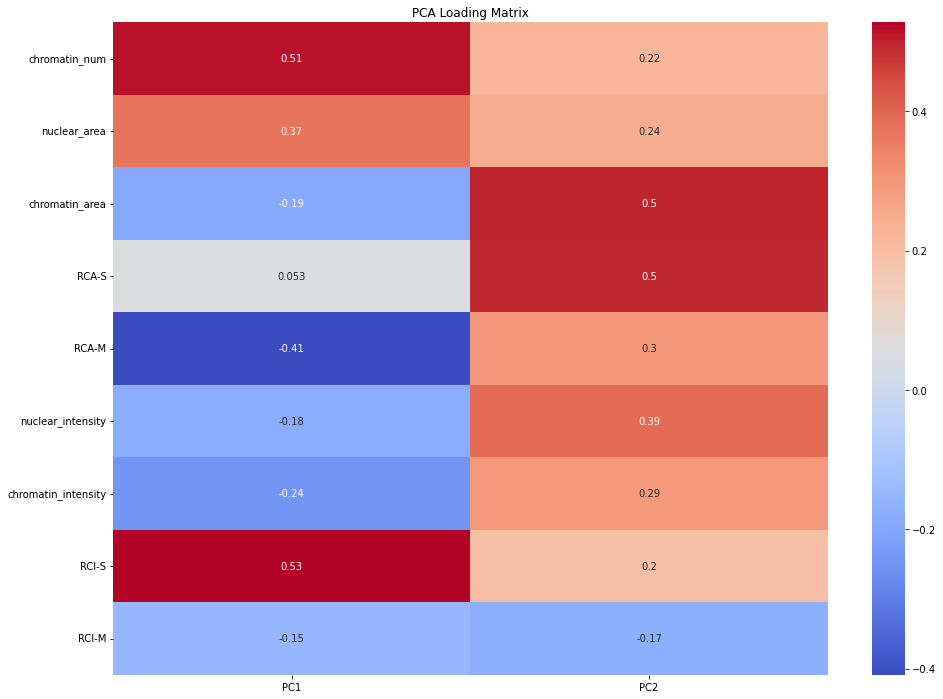

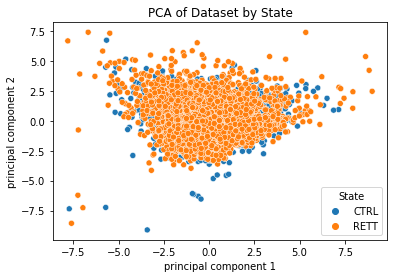

############################################################

LOAD tables/features_chromatin/RETT_HPS9999_CTCF.csv (3595, 9)
LOAD tables/features_chromatin/CTRL_CTCF.csv (1723, 9)
📊 PCA
Explained variance ratio: [0.36053394 0.30880002]


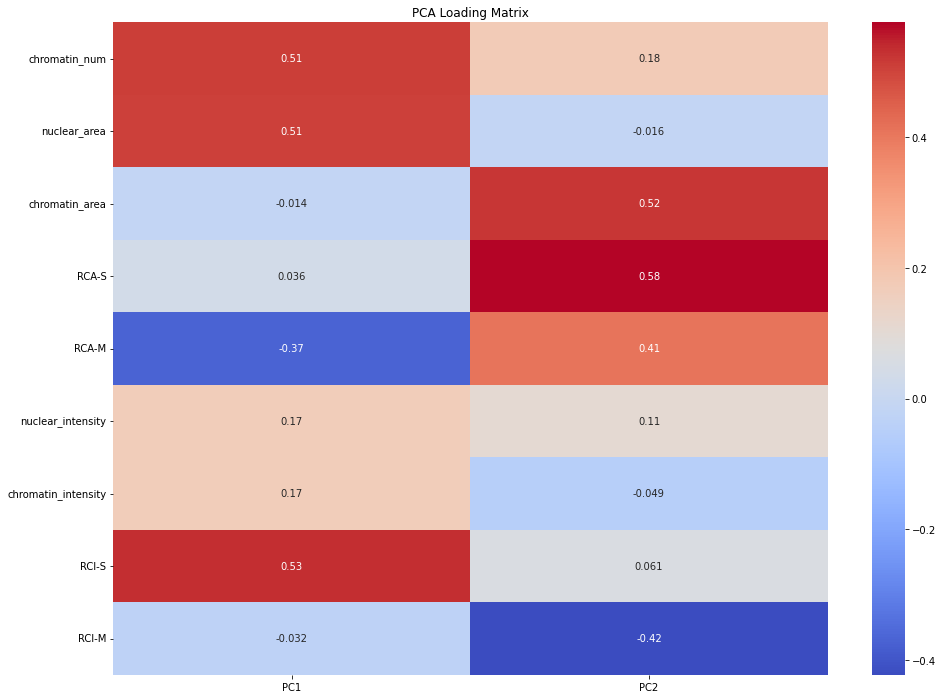

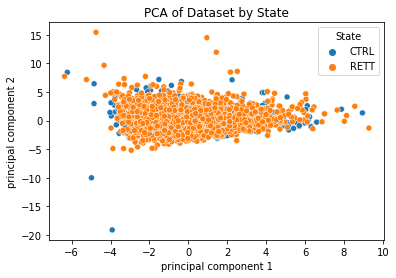

############################################################



In [10]:
# Feature image
# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF"]:
        df_combined, df_RETT, df_CTRL = loadcsv_Standard(rett_type, stain_type)
        
        validate_pca(df_combined, df_RETT, df_CTRL)
        
        print("############################################################")
        print("")

# BOX 箱型图

In [5]:
def validata_boxplot(data_all, feature, rett_type, saveto="features_chromatin"):
    # 假设 data_all 是之前整理好的 DataFrame
    unique_stains = data_all['Stain_Type'].unique()  # 获取所有染色类型
    p_values = []
    # 计算每种染色类型的 p 值
    for stain in unique_stains:
        group_ctrl = data_all[(data_all['State'] == 'CTRL') & (data_all['Stain_Type'] == stain)][feature]
        group_rett = data_all[(data_all['State'] == 'RETT') & (data_all['Stain_Type'] == stain)][feature]
        _, p_val = ttest_ind(group_ctrl, group_rett)
        p_values.append(p_val)
    for i in range(len(unique_stains)):
        print(f"p-value {unique_stains[i]}: {p_values[i]}")

    # 设置颜色
    palette_colors = {"CTRL": sns.color_palette(palette='bwr')[0], 
                      "RETT": sns.color_palette(palette='Pastel1')[0]}  # CTRL 使用绿色，RETT 使用紫色
    # 绘制箱型图
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Stain_Type', y=feature, hue='State', data=data_all, palette=palette_colors)
    plt.title(f'{feature} with Stains and Cell States')
    plt.ylabel(f'{feature}')
    plt.xlabel('Stain Type')
    plt.legend(title='Cell State')
    plt.savefig(f'tables/{saveto}/{rett_type}_{feature}.png', dpi=300)
    plt.show()

🦠🦠🦠  HPS9999
LOAD tables/features_chromatin/RETT_HPS9999_H3K27ac.csv (3041, 9)
LOAD tables/features_chromatin/CTRL_H3K27ac.csv (1369, 9)
LOAD tables/features_chromatin/RETT_HPS9999_CTCF.csv (3554, 9)
LOAD tables/features_chromatin/CTRL_CTCF.csv (1704, 9)
['chromatin_num', 'nuclear_area', 'chromatin_area', 'RCA-S', 'RCA-M', 'nuclear_intensity', 'chromatin_intensity', 'RCI-S', 'RCI-M', 'State'] 

💠 Fearure - HPS9999 - chromatin_num
p-value H3K27ac: 3.486484498816896e-26
p-value CTCF: 3.394943334980471e-21


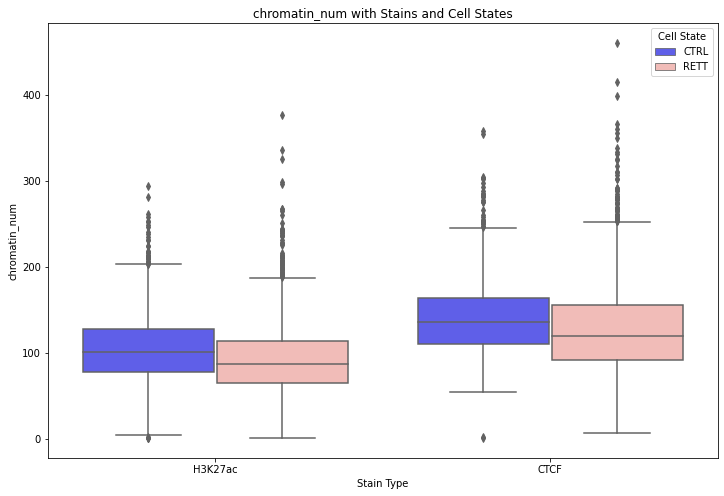

💠 Fearure - HPS9999 - chromatin_area
p-value H3K27ac: 1.1777098961649906e-31
p-value CTCF: 7.150425046021745e-112


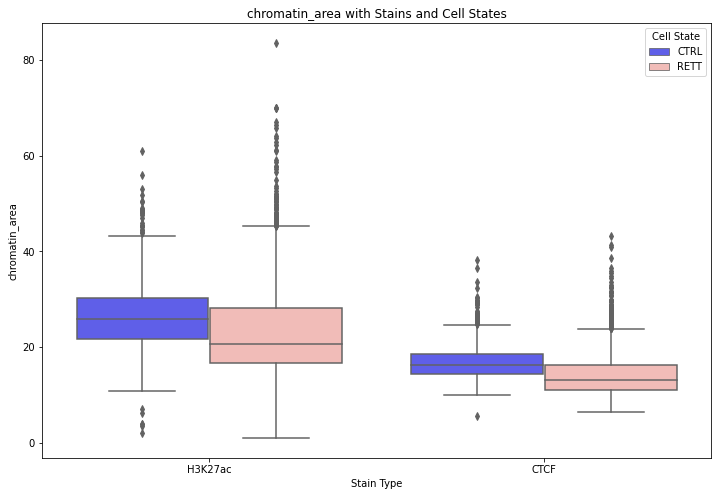

In [6]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()

# for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
for rett_type in ["HPS9999"]:
    print("🦠🦠🦠 ", rett_type)
    for stain_type in ["H3K27ac", "CTCF"]:
        # 假设 loadcsv 函数返回的 df_combined 已包含状态标签
        df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type, features="features_chromatin")
        df_combined['Stain_Type'] = stain_type  # 添加染色类型列
        data_all = pd.concat([data_all, df_combined])  # 合并数据

    features = df_CTRL.columns.tolist()
    print(features, "\n")
    for feature in ['chromatin_num', 'chromatin_area']:
        print(f"💠 Fearure - HPS9999 - {feature}")
        validata_boxplot(data_all, feature, rett_type, saveto="features_chromatin")
#         validata_violinplot(data_all, feature, rett_type, saveto="features_chromatin")

In [2]:
def loadcsv(rett_type, stain_type, features="features_chromatin", sub="none"):
    loadpath_RETT = f"tables/{features}/RETT_{rett_type}_{stain_type}-{sub}.csv"
    loadpath_CTRL = f"tables/{features}/CTRL_{stain_type}-{sub}.csv"

    # 读取 CSV 文件
    df_RETT = pd.read_csv(loadpath_RETT).dropna()
    df_CTRL = pd.read_csv(loadpath_CTRL).dropna()
    print(f"LOAD {loadpath_RETT} {df_RETT.shape}")
    print(f"LOAD {loadpath_CTRL} {df_CTRL.shape}")
    
    # 添加状态标签
    df_RETT['State'] = 'RETT'
    df_CTRL['State'] = 'CTRL'
    
    # 合并数据
    df_combined = pd.concat([df_CTRL, df_RETT])
    
    return df_combined, df_RETT, df_CTRL

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def validata_boxplot(data_all, feature, rett_type, saveto="features_chromatin", ylim=None):
    # 获取所有唯一的染色类型并计算 p 值
    unique_stains = ['H3K27ac', 'H3K27ac_LR', 'CTCF', 'CTCF_LR']  # 确保顺序
    p_values = []
    for stain in unique_stains:
        group_ctrl = data_all[(data_all['State'] == 'CTRL') & (data_all['Stain_Type'] == stain)][feature]
        group_rett = data_all[(data_all['State'] == 'RETT') & (data_all['Stain_Type'] == stain)][feature]
        # 检测样本大小，只有当两组中都有数据时，才进行 t 测试
        if not group_ctrl.empty and not group_rett.empty:
            _, p_val = ttest_ind(group_ctrl, group_rett)
            p_values.append(p_val)
        else:
            p_values.append('N/A')  # 没有足够数据的情况

    # 打印 p 值
    for i in range(len(unique_stains)):
        print(f"p-value for {unique_stains[i]}: {p_values[i]}")

    # 设置颜色
    palette_colors = {"CTRL": sns.color_palette("bwr")[0], "RETT": sns.color_palette("Pastel1")[0]}

    # 绘制箱型图
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Stain_Type', y=feature, hue='State', data=data_all, 
                palette=palette_colors, order=unique_stains)
    plt.title(f'{feature} with Stains and Cell States')
    plt.ylabel(f'{feature}')
    plt.xlabel('Stain Type')
    plt.legend(title='Cell State')
    plt.xticks(rotation=45)  # 可能需要旋转标签以更好地显示
    if ylim!=None:
        plt.ylim(0, ylim)  # 设置y轴范围
    plt.savefig(f'tables/{saveto}/SRLR_{rett_type}_{feature}.png', dpi=300)
    plt.show()

LOAD tables/features_chromatin/RETT_HPS9999_H3K27ac-1000.csv (3584, 10)
LOAD tables/features_chromatin/CTRL_H3K27ac-1000.csv (1719, 10)
LOAD tables/features_chromatinLR/RETT_HPS9999_H3K27ac-1000.csv (2821, 10)
LOAD tables/features_chromatinLR/CTRL_H3K27ac-1000.csv (1154, 10)
LOAD tables/features_chromatin/RETT_HPS9999_CTCF-1000.csv (3591, 10)
LOAD tables/features_chromatin/CTRL_CTCF-1000.csv (1722, 10)
LOAD tables/features_chromatinLR/RETT_HPS9999_CTCF-1000.csv (3158, 10)
LOAD tables/features_chromatinLR/CTRL_CTCF-1000.csv (1489, 10)
['chromatin_num', 'nuclear_area', 'chromatin_area', 'RCA-S', 'RCA-M', 'nuclear_intensity', 'chromatin_intensity', 'RCI-S', 'RCI-M', 'axis_ratio', 'State'] 

💠 Fearure - HPS9999 - chromatin_num
p-value for H3K27ac: 8.998867564259583e-34
p-value for H3K27ac_LR: 0.6237753860713982
p-value for CTCF: 1.379581773723049e-21
p-value for CTCF_LR: 0.0025474575161545604


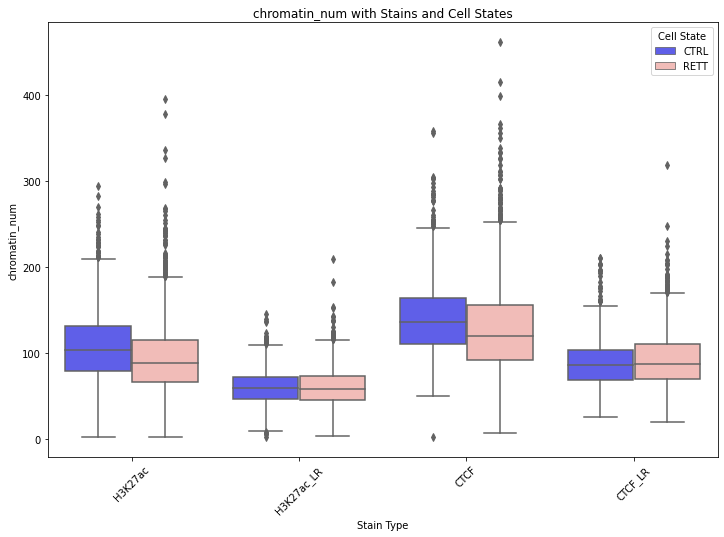

💠 Fearure - HPS9999 - axis_ratio
p-value for H3K27ac: 1.6113628642629292e-18
p-value for H3K27ac_LR: 0.000333868468250456
p-value for CTCF: 7.248162167996585e-87
p-value for CTCF_LR: 1.1145455611324173e-34


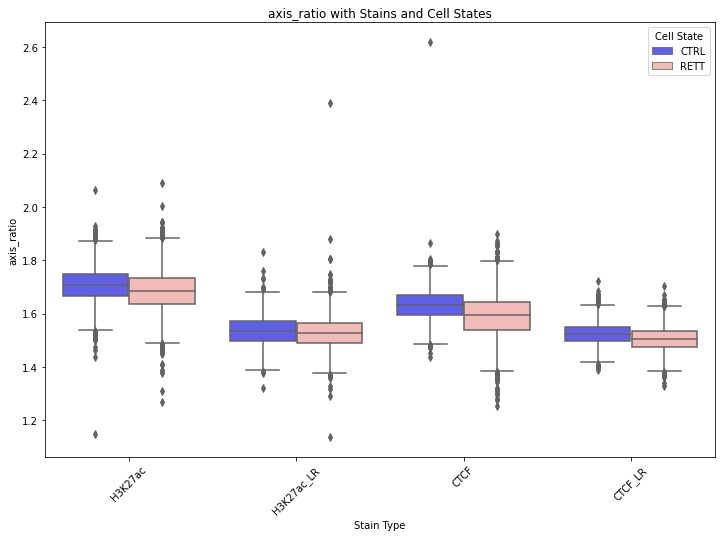

In [10]:
# 创建一个空的 DataFrame 用于存放所有数据
data_all = pd.DataFrame()
sub = "1000"

rett_type = "HPS9999"
for stain_type in ["H3K27ac", "CTCF"]:
    # SR
    df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type, features="features_chromatin", sub=sub)
    df_combined['Stain_Type'] = stain_type  # 添加染色类型列
    data_all = pd.concat([data_all, df_combined])  # 合并数据
    # LR
    df_combined, df_RETT, df_CTRL = loadcsv(rett_type, stain_type, features="features_chromatinLR", sub=sub)
    df_combined['Stain_Type'] = stain_type+"_LR"  # 添加染色类型列
    data_all = pd.concat([data_all, df_combined])  # 合并数据
    
data_all["Stain_Type"]

features = df_CTRL.columns.tolist()
print(features, "\n")
for feature in ['chromatin_num', 'axis_ratio']:
    print(f"💠 Fearure - HPS9999 - {feature}")
    validata_boxplot(data_all, feature, rett_type, saveto="features_chromatin")

💠 Fearure - HPS9999 - chromatin_area
p-value for H3K27ac: 1.0734806083253427e-15
p-value for H3K27ac_LR: 2.3611739810051574e-61
p-value for CTCF: 1.6883634517025142e-84
p-value for CTCF_LR: 1.5718041883029372e-87


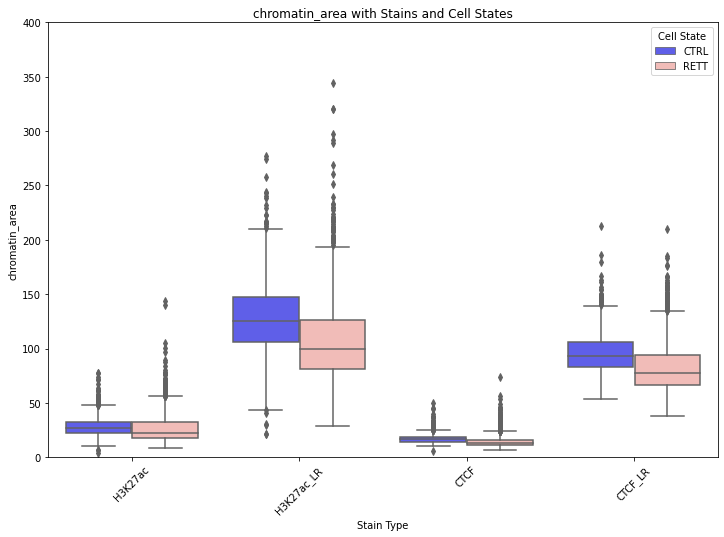

In [12]:
print(f"💠 Fearure - HPS9999 - chromatin_area")
validata_boxplot(data_all, 'chromatin_area', rett_type, saveto="features_chromatin", ylim=400)

In [9]:
import numpy as np

original_resolution = 50  # nm/px
sigma = (11 - 1) / 6
effective_resolution = np.sqrt((sigma * original_resolution)**2 + original_resolution**2)

print(f"Effective resolution after Gaussian blur: {effective_resolution:.2f} nm/px")

Effective resolution after Gaussian blur: 97.18 nm/px
